# Example Playbook for rasterization of gbif data
Author: Georg Seyerl\
Date: 2024-08-23

Rhododendron ferrugineum Data in Austria

In [1]:
import pandas as pd

import dask_geopandas
import geopandas as gpd

import xarray as xr
import numpy as np

import rasterio
import rioxarray

In [2]:
# Create dask client
import dask.dataframe as dd
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 30.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39639,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 30.00 GiB
Comm: tcp://127.0.0.1:40133,Total threads: 2
Dashboard: http://127.0.0.1:44479/status,Memory: 7.50 GiB
Nanny: tcp://127.0.0.1:46021,


# GBIF data

Load gbif dataset

In [3]:
# https://docs.dask.org/en/stable/dataframe-best-practices.html
# Load occurance dataset with selected columns and specified datatypes
pdf_gbif = pd.read_csv("/home/susannaioni/s3/data/gbif/R_Ferr/occurrence.txt", 
                  sep="\t", 
                  index_col="gbifID",
                  usecols=["gbifID", 
                           "collectionCode", 
                           "basisOfRecord", 
                           "eventDate", 
                           "year",
                           "month",
                           "day",
                           "decimalLatitude", 
                           "decimalLongitude",
                           "countryCode",
                           "coordinateUncertaintyInMeters",
                           "scientificName",
                           "basisOfRecord",
                           "datasetName",
                           "recordedBy"
                          ],
                  dtype={"year":"Int32",
                         "month":"Int32",
                         "day":"Int32",
                         "decimalLatitude":"Float32",
                         "decimalLongitude":"Float32",
                         "countryCode":"str",
                         "coordinateUncertaintyInMeters":"Float32",
                         "scientificName":"str",
                         "basisOfRecord":"str",
                         "datasetName":"str",
                         "recordedBy":"str"},
)

In [4]:
# Filter data based on some criterias
filter = ( pdf_gbif["scientificName"].isin(['Rhododendron ferrugineum L.']) ) & \
         ( pd.to_numeric(pdf_gbif["coordinateUncertaintyInMeters"], errors='coerce') <= 100 )
         #( pdf_gbif["countryCode"].isin(['AT']) )
pdf_gbif = pdf_gbif[filter] 

In [5]:
# Add boolean columns for each species in gbif dataframe
pdf_gbif = pd.concat([pdf_gbif, pd.get_dummies(pdf_gbif.scientificName, prefix="OCC")], axis=1)

In [6]:
# Data cleanup and filtering --------------------------------------------------------------------------------
# Drop all rows with nan values in year or month
pdf_gbif = pdf_gbif.dropna(subset=['year','month'])
# Only use data with year bigger/equal 1940 and smaller/equal 2023 and sort by date
pdf_gbif = pdf_gbif[(pdf_gbif.year>=1940) & (pdf_gbif.year<=2023)].sort_values(by=["year","month","day"])
# New time column with year and month as string
pdf_gbif['date'] = pdf_gbif['year'].astype(str) + '-' + pdf_gbif['month'].astype(str)
# Convert string to datetime
pdf_gbif['date'] = pd.to_datetime(pdf_gbif['date'], format='%Y-%m')

In [7]:
# Rename to sane names
pdf_gbif = pdf_gbif.rename({'decimalLatitude':'latitude', 'decimalLongitude':'longitude'}, axis=1)

In [8]:
pdf_gbif.head()

,collectionCode,datasetName,basisOfRecord,recordedBy,eventDate,year,month,day,countryCode,latitude,longitude,coordinateUncertaintyInMeters,scientificName,OCC_Rhododendron ferrugineum L.,date
gbifID,,,,,,,,,,,,,,,
3941349539,NaN,NaN,HUMAN_OBSERVATION,PNE,1977-06-16,1977,6,16,FR,44.9664,6.17803,100.0,Rhododendron ferrugineum L.,True,1977-06-01
3933272890,NaN,NaN,HUMAN_OBSERVATION,VILLARET Jean-Charles,1979-06-25,1979,6,25,FR,44.993801,6.12593,10.0,Rhododendron ferrugineum L.,True,1979-06-01
3933366229,NaN,NaN,HUMAN_OBSERVATION,VILLARET Jean-Charles,1979-06-26,1979,6,26,FR,45.002201,6.13387,10.0,Rhododendron ferrugineum L.,True,1979-06-01
3933057076,NaN,NaN,HUMAN_OBSERVATION,VILLARET Jean-Charles,1979-06-30,1979,6,30,FR,44.994621,6.1274,10.0,Rhododendron ferrugineum L.,True,1979-06-01
3933164348,NaN,NaN,HUMAN_OBSERVATION,VILLARET Jean-Charles,1979-07-06,1979,7,6,FR,45.003311,6.15762,10.0,Rhododendron ferrugineum L.,True,1979-07-01


# Convert dataframe to xarray Dataset as sparse array with lat and lon

Rasterization of gbif Data for Rhododendron Ferrugineum

## Use Xarray
TODO for big data analytics: 
 - Regrid sparse arrays on multiple dimension \
   _IndexError: Only one-dimensional iterable indices supported._
 - Dask Dataframe as gbif source

In [9]:
# Convert dataframe to xarray Dataset
xds_gbif = pdf_gbif.to_xarray()

In [10]:
# Don not use all variables in this showcase
xds_gbif = xds_gbif[['OCC_Rhododendron ferrugineum L.','latitude','longitude']]

In [11]:
# Set lat and lon as coordinates
xds_gbif = xds_gbif.set_coords(["latitude","longitude"])

In [12]:
# One dimension gbifID from dataframe
xds_gbif

<xarray.Dataset> Size: 237kB
Dimensions:                          (gbifID: 13914)
Coordinates:
    latitude                         (gbifID) float32 56kB 44.97 44.99 ... 42.48
    longitude                        (gbifID) float32 56kB 6.178 6.126 ... 2.321
  * gbifID                           (gbifID) int64 111kB 3941349539 ... 4516...
Data variables:
    OCC_Rhododendron ferrugineum L.  (gbifID) bool 14kB True True ... True True

In [13]:
# Set a new index based on lat/lon, drop duplicates in locations and unstack lat/lon
xds_gbif = xds_gbif.set_index(gbifID=("latitude", "longitude")).drop_duplicates('gbifID').unstack("gbifID")#, sparse=True)

In [14]:
xds_gbif

<xarray.Dataset> Size: 1GB
Dimensions:                          (latitude: 12685, longitude: 12805)
Coordinates:
  * latitude                         (latitude) float32 51kB 36.74 ... 54.3
  * longitude                        (longitude) float32 51kB -8.868 ... 21.05
Data variables:
    OCC_Rhododendron ferrugineum L.  (latitude, longitude) object 1GB nan ......

In [15]:
# Fill missing values with False and convert to int8 for tif creation. I would prefer boolean
xds_gbif['OCC_Rhododendron ferrugineum L.'] = xds_gbif["OCC_Rhododendron ferrugineum L."].fillna(False).astype("int8")

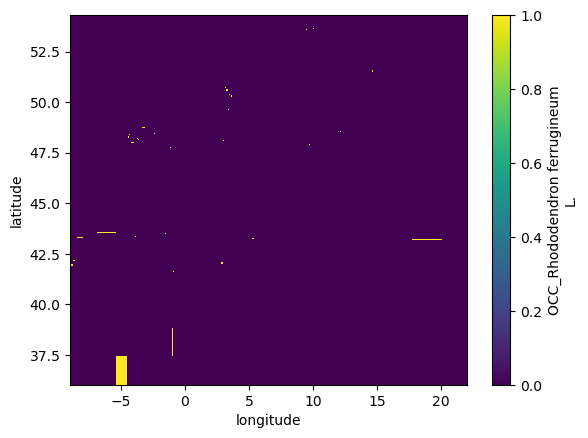

In [16]:
# This is an irregular grid now !!!
xds_gbif["OCC_Rhododendron ferrugineum L."].plot()

### Regrid data

In [17]:
# Reindex to regular grid with nearest value and a tolerance of 0.05°. Fill missing values with False
# If there is a reference grid we may use xarrays reindex_like:
# https://docs.xarray.dev/en/stable/generated/xarray.Dataset.reindex_like.html
xds_gbif = xds_gbif.reindex({"latitude":np.linspace(xds_gbif.latitude.min(), xds_gbif.latitude.max(), 5000),
                             "longitude":np.linspace(xds_gbif.longitude.min(), xds_gbif.longitude.max(), 5000)},
                            method="nearest", 
                            tolerance=0.05, 
                            fill_value=False)

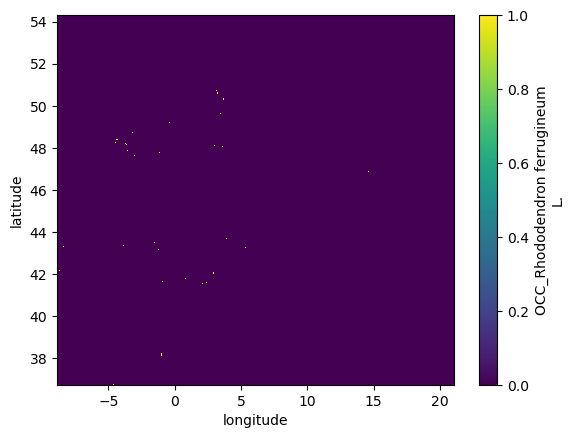

In [18]:
# This is a regular grid now
xds_gbif["OCC_Rhododendron ferrugineum L."].plot()

In [19]:
xds_gbif.rio.to_raster('occ_R_ferr.tif', tiled=True, nbits=1)#,lock=Lock("rio", client=client))